In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle") 
import quandl
import functools

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you make your own.

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

# 1 Introduction

A spread trading strategy checks a running estimate of the displacement between two related instruments, and makes bets that this displacement will decline whenever it gets large. Here, we define that displacement in terms of recent returns.

In [2]:
START_DATE    = "2019-12-02"
END_DATE      = "2021-12-31"

QUANDL_DB     = "QUOTEMEDIA/PRICES"
QUANDL_ASSETS = ["FCOM", "VOX"]

FF_TABLE      = "F-F_Research_Data_Factors_daily"
FF_DB         = "famafrench"

In [3]:
if "pull_quandl" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    @functools.lru_cache(maxsize=16)
    def pull_quandl(db, assets, start_date, end_date):
        ret = quandl.get_table(db, ticker=list(assets), 
                               date={"gte":START_DATE, "lte":END_DATE})
        return ret

eod_raw = pull_quandl(QUANDL_DB, tuple(QUANDL_ASSETS), START_DATE, END_DATE)
display(eod_raw.head(3))

Defining quandl pull


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,VOX,2021-12-31,136.8700,137.3300,135.5100,135.5600,78065.0000,0.0000,1.0000,136.8700,137.3300,135.5100,135.5600,78065.0000
1,VOX,2021-12-30,136.7800,137.9900,136.7800,137.1900,114214.0000,0.0000,1.0000,136.7800,137.9900,136.7800,137.1900,114214.0000
2,VOX,2021-12-29,137.1000,137.5300,136.0950,136.5000,97534.0000,0.0000,1.0000,137.1000,137.5300,136.0950,136.5000,97534.0000


In [4]:
ff_raw = pdr.data.DataReader(FF_TABLE, FF_DB, 
                            ''.join(START_DATE.split('-')),
                            ''.join(END_DATE.split('-')))

ff_raw[0].head(3)

,Mkt-RF,SMB,HML,RF
Date,,,,
2019-12-02,-0.8700,-0.2400,0.4600,0.0070
2019-12-03,-0.6600,0.6000,-0.8300,0.0070
2019-12-04,0.6000,0.1300,0.2500,0.0070


In [5]:
q_adj_close = eod_raw[["date", "ticker", "adj_close"]].pivot(
    index="date", columns="ticker", values="adj_close")
q_log_ret = np.log(q_adj_close / q_adj_close.shift(1))

f_ret = ff_raw[0] / 100
f_ret.index.name = "date"
f_level = np.exp(f_ret.cumsum())

levels = q_adj_close.merge(f_level, on="date")
ret = q_log_ret.merge(f_ret, on="date")

etfs_facts = pd.concat([levels, ret], axis=1, keys=["level", "ret"])
display(etfs_facts)

level                                          ret          \
              FCOM      VOX Mkt-RF    SMB    HML     RF    FCOM     VOX   
date                                                                      
2019-12-02 34.1469  89.3003 0.9913 0.9976 1.0046 1.0001     NaN     NaN   
2019-12-03 34.1273  89.1632 0.9848 1.0036 0.9963 1.0001 -0.0006 -0.0015   
2019-12-04 34.2748  89.6723 0.9907 1.0049 0.9988 1.0002  0.0043  0.0057   
2019-12-05 34.4125  89.9464 0.9920 1.0028 1.0034 1.0003  0.0040  0.0031   
2019-12-06 34.6288  90.5143 1.0011 1.0052 1.0073 1.0004  0.0063  0.0063   
...            ...      ...    ...    ...    ...    ...     ...     ...   
2021-11-23 52.3500 137.6696 1.6748 1.1441 0.9142 1.0052 -0.0040 -0.0040   
2021-11-24 52.4400 137.8290 1.6798 1.1443 0.9064 1.0052  0.0017  0.0012   
2021-11-26 51.5700 135.4972 1.6430 1.1303 0.8980 1.0052 -0.0167 -0.0171   
2021-11-29 51.8100 136.2147 1.6613 1.1190 0.8902 1.0052  0.0046  0.0053   
2021-11-30 50.2800 132.2585 1.6292 1.1247 0.8803 1.0052 -0.0300 -0.0295   

                                           
            Mkt-RF     SMB     HML     RF  
date                                       
2019-12-02 -0.0087 -0.0024  0.0046 0.0001  
2019-12-03 -0.0066  0.0060 -0.0083 0.0001  
2019-12-04  0.0060  0.0013  0.0025 0.0001  
2019-12-05  0.0013 -0.0021  0.0046 0.0001  
2019-12-06  0.0091  0.0024  0.0039 0.0001  
...            ...     ...     ...    ...  
2021-11-23 -0.0003 -0.0051  0.0174 0.0000  
2021-11-24  0.0030  0.0002 -0.0086 0.0000  
2021-11-26 -0.0222 -0.0123 -0.0093 0.0000  
2021-11-29  0.0111 -0.0101 -0.0087 0.0000  
2021-11-30 -0.0195  0.0051 -0.0112 0.0000  

[504 rows x 12 columns]

# 2 Data

Obtain split- and dividend-adjusted closing prices1 for 2 Dec 2019 though 31 Dec 2021 of a pair of ETFs (which we will call X and Y ) as specified below. Estimate daily dollar volume, compute the running trailing 15-trading-day median of it over our sample period for X, and denote that running median (as of any day given t) for the less liquid of the two ETFs with the expression Nt.

In [6]:
q_adj_volm = eod_raw[["date", "ticker", "adj_volume"]].pivot(
    index="date", columns="ticker", values="adj_volume")

V_t = q_adj_volm * q_adj_close

window = 15

med = V_t.rolling(window).median().shift(1) # Shift to avoid lookahead bias
less_liquid = med.mean().idxmin()
N_t = med[less_liquid] # For position sizing
etfs_facts[("volm", "N_t")] = N_t
N_t

date
2019-12-02            NaN
2019-12-03            NaN
2019-12-04            NaN
2019-12-05            NaN
2019-12-06            NaN
                 ...     
2021-12-27   4966963.8400
2021-12-28   4856834.6400
2021-12-29   4744459.1800
2021-12-30   4433092.9700
2021-12-31   4433092.9700
Name: FCOM, Length: 526, dtype: float64

# 3 Exercise 

## 3.1 Positions

Create code for a spread-reversion trading strategy that begins on the first day of each month, trades during the month, and closes any open positions the end of each month (i.e. the first potential day for a trade is just after January 1 2020). For this homework, make the unrealistic assumption that you can trade at end-of-day closing prices from the database.

Its trades are equal-sized dollar amounts of X and Y to the nearest integer number of shares, as close as possible to \\$ Nt / 100 of each. Note that Nt changes every day, so trade size will depend on which day you open the position. Your gross traded cash is therefore roughly \\$2Nt/100. Track this number on any open position for later stop loss calculations.

The strategy enters or maintains a position if the size s of difference between the M-day return on X and Y is greater than g, and flattens (exits) the position if the size of the difference is less than j (where j < g). It does so by shorting the security whose recent return is higher. Note that if the change in s is large enough the position can flip from shorting the spread to being long the spread and vice versa, as discussed in class.
You only ever hold, at most, one long and one short position (i.e. one spread position). If you already have a position and the next tick is favorable to it, this simply means you continue to hold the position (except in stop loss situations). Do not adjust position size with the new Nt.

## 3.2 Mark To Market

When a position is open, keep track of its profits/losses (PnL). You will also want to keep track of cumulative PL across the whole series of opened and closed positions.

## 3.3 Stop Loss

Include a stop loss parameter s in your strategy. If your simulation ex- periences a day such that the present position value has lost more than a proportion s of the gross traded cash (|$long| + |$short| at position entry time), then force an exit at current prices, assume no new positions for the remainder of the month, and include this in your accounting.

## 3.4 End Of Data

Force a position close at the end of the analysis period.

## 3.5 Capital

Set the capital K for your strategy to the maximum of Nt over the data
period, times two3. You can use this to evaluate return on capital.

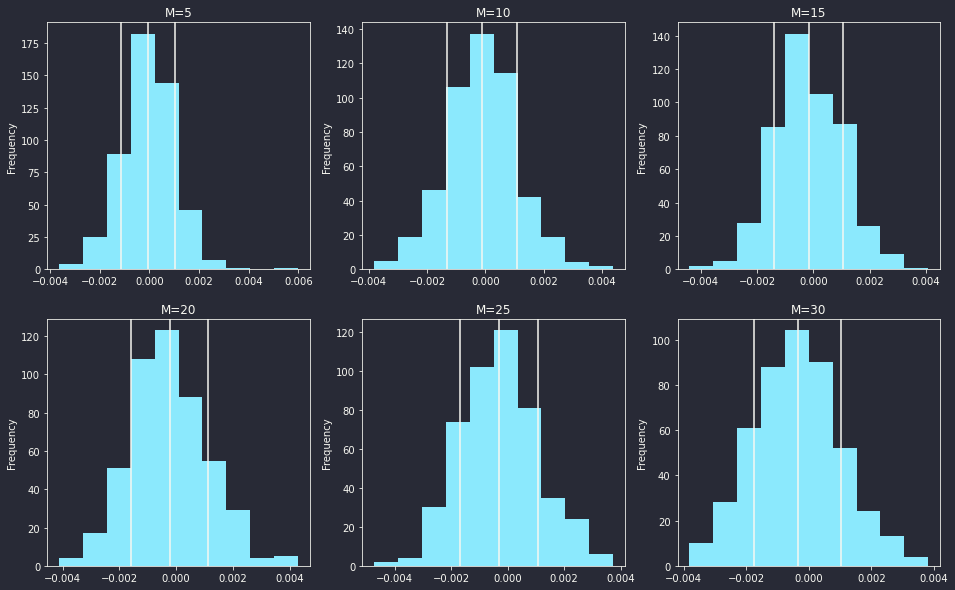

In [7]:
def construct_spread(data, assets, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    M: int                   accumulation window for spread"""
    strat = pd.DataFrame()
    for a, l in zip(assets, ["XR", "YR"]): strat[l] = data[("ret",a)]
    strat["tgt_size"] = data[("volm", "N_t")] / 100
    strat["signal"] = (strat["XR"].rolling(M).sum() 
                       - strat["YR"].rolling(M).sum())
    return strat
    
def vis_hist(ser, ax, stats):
    ser.plot.hist(ax=ax)
    mu = stats["mean"]; sig = stats["std"]
    ax.set_title(f"M={stats['M']}")
    ax.axvline(mu); ax.axvline(mu+sig); ax.axvline(mu-sig)

fig, axs = plt.subplots(2,3)
plt_counter = 0

strat_stats = []

for M in range(1,31):
    strat_ = construct_spread(etfs_facts, QUANDL_ASSETS, M)
    sig = strat_["signal"]
    
    stats = {"M": M, "strat": strat_, "mean": sig.mean(),
             "std": sig.std(), "skew": sig.skew(), "kurt": sig.kurtosis()}
    strat_stats.append(stats)
    
    if not(M%5):
        vis_hist(strat_["signal"], axs[plt_counter//3, plt_counter%3], stats)
        plt_counter += 1

strat_stats = pd.DataFrame(strat_stats).set_index('M')
plt.show()

## Histograms as `M` Increases

Decreasing Kurtosis (fatter tails), decreasing Mean. Increasing Standard Deviation.

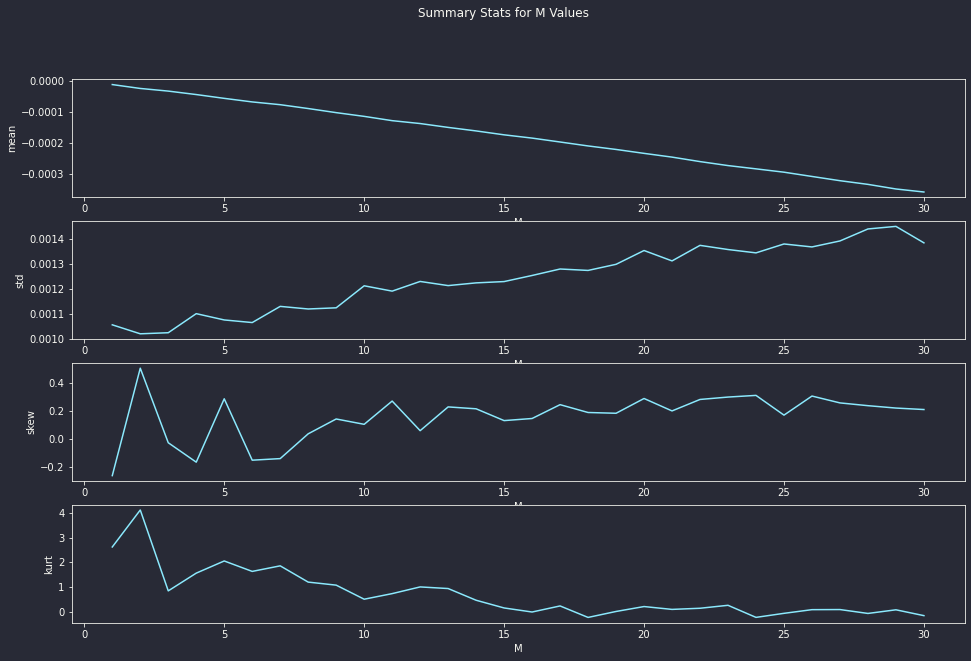

In [8]:
cols = strat_stats.columns[1:]
fig, axs = plt.subplots(len(cols))

for i, c in enumerate(cols):
    strat_stats[c].plot(ax=axs[i])
    axs[i].set_ylabel(c)
plt.suptitle("Summary Stats for M Values")
plt.show()

## Spread Summary Stats

Mean trends down, Standard Deviation trends up as $\sqrt{t}$. Skew and Kurtosis stabilize after 15.

Therefore, when tuning `g` and `j`, we should scale them according to $\sqrt{M}$

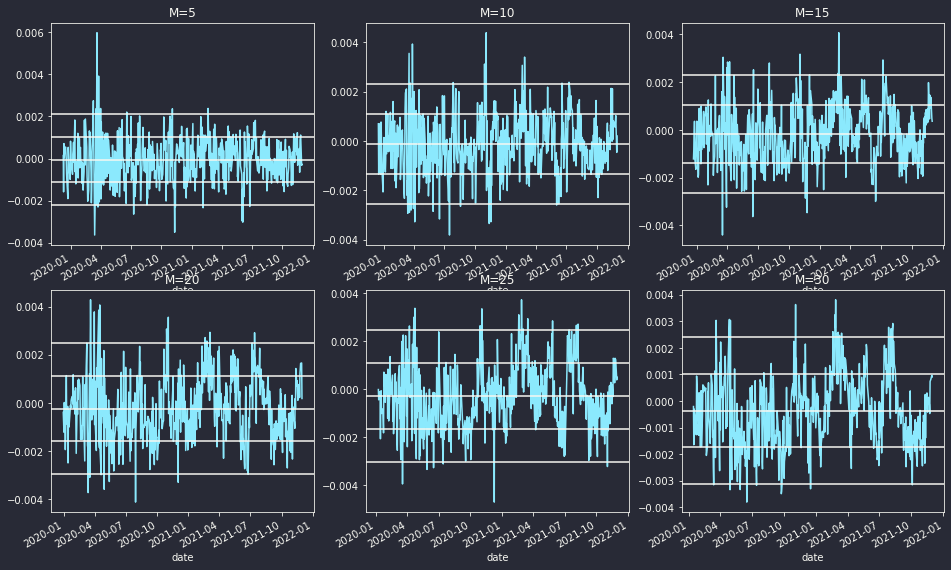

In [9]:
def ts_stats(row, ax):
    ser = row["strat"]["signal"]
    ser.plot(ax=ax)
    mu = row["mean"]; sig = row["std"]
    ax.set_title(f"M={row.name}")
    ax.axhline(mu); ax.axhline(mu+sig); ax.axhline(mu-sig)
    ax.axhline(mu+2*sig); ax.axhline(mu-2*sig)

fig, axs = plt.subplots(2,3)

for i in range(6):
    ts_stats(strat_stats.loc[5*(i+1),:], axs[i//3,i%3])

plt.show()

## Spread $\mu$ and $\sigma$

Tune `g` and `j` to capture profit opportunities while not risking blowing up. `g` and `j` should be a function of $\sigma$(`M`), though we do not want to introduce lookahead bias.

`M` over 20 have spreads that cluster too significantly (reverts too slowly). Under 10 tends to be too unstable (significant breach of Stop Loss without exit opportunity, leading to ruin).

In [167]:
def construct_strategy(data, assets, g, j, s, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    g: float                 position entry parameter
    j: float                 position exit parameter
    s: float                 stop loss parameter
    M: int                   accumulation window for spread
    Constraint g > j > 0
    """
    # ---------------------------------------------------------------------
    def execute_strat(df, g=g, j=j, s=s, M=M):
        n = len(df)

        changes, positions = [], []
        dxs, dys, imbal = [], [], []
        x_pos, y_pos, profit = [], [], []

        # Starting day
        row = df.iloc[0]
        curr_chg = row["ltg"] - row["gtg"]
        curr_pos = curr_chg
        dx = curr_chg * row["XSz"]
        dy = -curr_chg* row["YSz"]
        imb = dx*row["XL"] + dy*row["YL"]
        x, y = 0, 0
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        dxs.append(dx), dys.append(dy)
        imbal.append(imb)
        x_pos.append(x); y_pos.append(y)

        for i in range(1, n-1):
            row = df.iloc[i]
            if curr_pos==0: # No position
                curr_chg = row["ltg"] - row["gtg"]
                if curr_chg:
                    dx = curr_chg * row["XSz"]
                    dy = -curr_chg* row["YSz"]
                else: dx, dy = 0, 0
                
            elif curr_pos>0: # Long position
                curr_chg = -row["gtj"] - row["gtg"]
                if curr_chg==0: dx, dy = 0,0
                elif curr_chg==-1: # Crosses -j: Close
                    dx, dy = -x, -y
                elif curr_chg==-2: # Crosses -j and +g: Reverse
                    dx = -row["gtg"]* row["XSz"] - x
                    dy = row["gtg"] * row["YSz"] - y
                    
            elif curr_pos<0: # Short position
                curr_chg = row["ltj"] + row["ltg"]
                if curr_chg==0: dx, dy = 0, 0
                elif curr_chg==1: # Crosses j: Close
                    dx, dy = -x, -y
                elif curr_chg==2: # Crosses j and -g: Reverse
                    dx = row["ltg"] * row["XSz"] - x
                    dy = -row["ltg"]* row["YSz"] - y
                    
            else: # Error
                pass
            
            x += dx
            y += dy
            curr_pos += curr_chg
            imb = dx*row["XL"] + dy*row["YL"]
            changes.append(curr_chg)
            positions.append(curr_pos)
            x_pos.append(x); y_pos.append(y)
            dxs.append(dx); dys.append(dy)
            imbal.append(imb)

        # Ending day
        row = df.iloc[-1]
        curr_chg, curr_pos = 0, 0
        dx, dy = -x, -y
        imb = dx*row["XL"] + dy*row["YL"]
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        x_pos.append(x); y_pos.append(y)
        dxs.append(dx); dys.append(dy)
        imbal.append(imb)

        trades = pd.DataFrame({"chg": changes, "pos": positions, 
                               "dX": dxs, "dY": dys,
                               "XPos": x_pos, "YPos": y_pos}, index=df.index)
        
        cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos']
        trades[cols] = trades[cols].fillna(0).astype(int)
        
        trades["XVal"] = trades["XPos"].shift(1) * df["XL"].diff()
        trades["YVal"] = trades["YPos"].shift(1) * df["YL"].diff()
        trades["pl"] = trades["XVal"] + trades["YVal"]
        trades["pl"].fillna(0, inplace=True)
        
        # gtc = 
        trades["gtc"] = np.abs(trades["XPos"]*df["XL"]-trades["YPos"]*df["YL"])
        trades["ret"] = np.log(trades["pl"] / trades["gtc"].shift(1) + 1).fillna(0)
        
        trades["comcap"] = (trades["chg"]!=0).astype(int) * trades["gtc"]
        trades["comcap"] = trades["comcap"].replace(to_replace=0, method='ffill')
        trades["stop"] = trades["comcap"] * (1-s)
        trades["stopped"] = (trades["gtc"]<trades["stop"]) & (trades["gtc"]>0.0001)
        trades["stopped"] = trades["stopped"].replace(to_replace=0, method='ffill')

        return trades
    
    # ---------------------------------------------------------------------
    
    strat = construct_spread(data, assets, M)
    signal = strat["signal"]
    
    for a, l in zip(assets, ["XL", "YL"]): strat[l] = data[("level", a)]
    strat["XSz"] = np.round(strat["tgt_size"].divide(strat["XL"],axis=0))
    strat["YSz"] = np.round(strat["tgt_size"].divide(strat["YL"],axis=0))
    
    strat["gtg"] = signal > g
    strat["ltg"] = signal < -g
    strat["gtj"] = signal > -j
    strat["ltj"] = signal < j
    
    if True: # Debug
        to_ints = ["gtg", "ltg", "gtj", "ltj"]
        strat[to_ints] = strat[to_ints].astype(int)
    
    strat["year"] = strat.index.year
    strat["month"] = strat.index.month
    
    trades = strat.groupby(["year", "month"]).apply(execute_strat)
    
    strat = pd.concat([trades, strat], axis=1)
    
    K = 2 * strat["tgt_size"].max()
    # Return on capital
    strat["roc"] = np.log((strat["pl"]+K) / K)
    
    cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
            'pl', 'ret', 'roc']
    strat.loc[strat["stopped"], cols] = 0
    return strat

g = 0.001 # Entry parameter
j = 0.00015 # Exit parameter
s = 0.001 # Stop Loss parameter
M = 10 # Accumulation window to determine spread divergence

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
mask = (strat["year"]==2020) & (strat["month"]==1)

cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
        'signal', 'XL', 'YL', 'gtc', 'pl', 'ret']
strat[mask][cols]

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,gtc,pl,ret
date,,,,,,,,,,,,
2020-01-02,0,0,0,0,0,0,0.0001,35.6728,93.3144,0.0000,0.0000,0.0000
2020-01-03,0,0,0,0,0,0,-0.0007,35.5250,92.9412,0.0000,-0.0000,0.0000
2020-01-06,1,1,489,-187,489,-187,-0.0013,35.9094,94.0411,35145.3851,0.0000,0.0000
2020-01-07,0,1,0,0,489,-187,-0.0008,35.9488,94.1000,35175.6842,8.2619,0.0002
2020-01-08,-2,-1,-994,380,-505,193,0.0012,36.1657,94.5812,36517.8505,16.0574,0.0005
2020-01-09,0,-1,0,0,-505,193,0.0004,36.2938,94.8660,36637.5277,-9.7465,-0.0003
2020-01-10,1,0,505,-193,0,0,-0.0005,36.1755,94.6598,0.0000,19.9315,0.0005
2020-01-13,-1,-1,-648,248,-648,248,0.0011,36.5501,95.5436,47379.2977,0.0000,0.0000
2020-01-14,1,0,648,-248,0,0,-0.0004,36.4811,95.5535,0.0000,47.1473,0.0010


In [166]:
strat[strat["stopped"]].head(20)

,chg,pos,dX,dY,XPos,YPos,XVal,YVal,pl,gtc,...,YL,XSz,YSz,gtg,ltg,gtj,ltj,year,month,roc
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,35.5348,-32.5255,0.0000,53568.5554,...,97.1149,938.0000,359.0000,0,0,1,0,2020,1,0.0000
2020-01-23,0,0,0,0,0,0,63.9627,-43.3673,0.0000,76211.4860,...,96.9578,1029.0000,393.0000,0,1,0,1,2020,1,0.0000
2020-01-24,0,0,0,0,0,0,-385.4322,439.9780,0.0000,75386.0758,...,95.8383,1215.0000,465.0000,0,0,0,1,2020,1,0.0000
2020-01-27,0,0,0,0,0,0,-598.4342,594.3563,0.0000,0.0000,...,94.3259,1159.0000,443.0000,0,0,1,0,2020,1,0.0000
2020-01-28,0,0,0,0,0,0,0.0000,0.0000,0.0000,83569.3052,...,95.3669,1147.0000,438.0000,0,1,0,1,2020,1,0.0000
2020-01-29,0,0,0,0,0,0,-180.8974,210.7676,0.0000,76278.4947,...,94.8857,1051.0000,402.0000,1,0,1,0,2020,1,0.0000
2020-01-30,0,0,0,0,0,0,300.4345,-276.3489,0.0000,0.0000,...,94.1982,967.0000,370.0000,0,0,0,1,2020,1,0.0000
2020-01-31,0,0,0,0,0,0,-0.0000,-0.0000,0.0000,0.0000,...,92.8135,1007.0000,385.0000,0,0,1,0,2020,1,0.0000
2020-02-21,0,0,0,0,0,0,-504.6045,497.7029,0.0000,70201.6433,...,96.9971,962.0000,367.0000,0,1,0,1,2020,2,0.0000


<AxesSubplot:xlabel='date'>

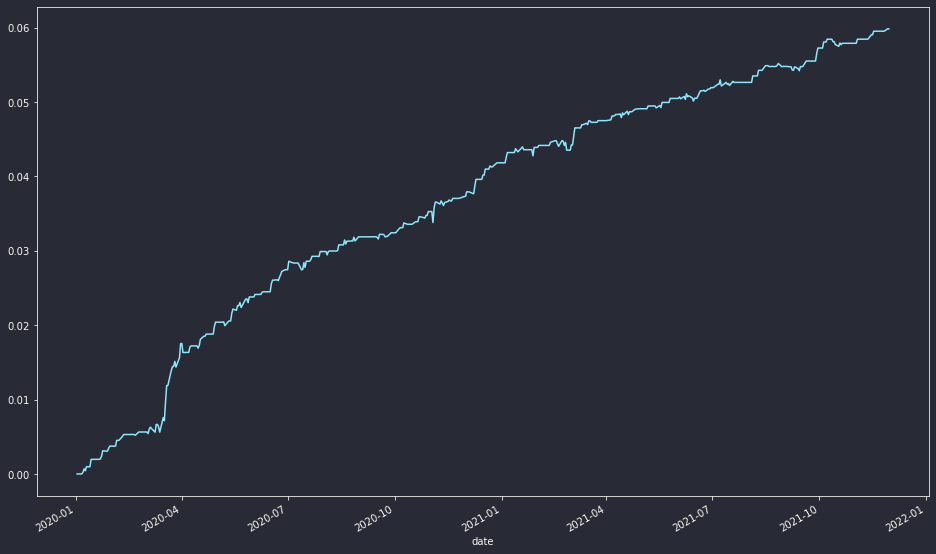

In [129]:
strat["2020":]["ret"].cumsum().plot()

In [101]:
jan = strat[mask][cols]
jan["pl"] = jan["dX"] * jan["XL"] + jan["dY"] * jan["YL"]
jan["cumu"] = jan["pl"].cumsum()
jan["csx"] = jan["dX"].cumsum()
jan

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,imb,pl,cf,cumu,csx
date,,,,,,,,,,,,,,
2020-01-02,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0001,35.6728,93.3144,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0007,35.5250,92.9412,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-06,1.0000,1.0000,489.0000,-187.0000,489.0000,-187.0000,-0.0013,35.9094,94.0411,-25.9881,-25.9881,-25.9881,-25.9881,489.0000
2020-01-07,-0.0000,1.0000,0.0000,0.0000,489.0000,-187.0000,-0.0008,35.9488,94.1000,0.0000,0.0000,0.0000,-25.9881,489.0000
2020-01-08,-2.0000,-1.0000,-994.0000,380.0000,-505.0000,193.0000,0.0012,36.1657,94.5812,-7.8260,-7.8260,-7.8260,-33.8141,-505.0000
2020-01-09,0.0000,-1.0000,0.0000,0.0000,-505.0000,193.0000,0.0004,36.2938,94.8660,0.0000,0.0000,0.0000,-33.8141,-505.0000
2020-01-10,1.0000,0.0000,505.0000,-193.0000,0.0000,0.0000,-0.0005,36.1755,94.6598,-0.6902,-0.6902,-0.6902,-34.5043,0.0000
2020-01-13,-1.0000,-1.0000,-648.0000,248.0000,-648.0000,248.0000,0.0011,36.5501,95.5436,10.3484,10.3484,10.3484,-24.1559,-648.0000
2020-01-14,1.0000,0.0000,648.0000,-248.0000,0.0000,0.0000,-0.0004,36.4811,95.5535,-57.4957,-57.4957,-57.4957,-81.6516,0.0000


a

In [11]:
a

NameError: name 'a' is not defined